In [116]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

import sys
import os
import time
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pybel
from rdkit.Chem import AllChem, DataStructs, SDMolSupplier, Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import HTML
from PIL import Image
import base64

from io import BytesIO

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [117]:
dir_temp = "DB3"
des = "morg"
try:
    print("done processing dataframe")
    str_temp = "../data/desc/" + dir_temp + "/desc_calc_" + dir_temp + "_" + des + ".pkl"
    print(str_temp)
    df = pd.read_pickle(str_temp)
    pkl = 1
except:
    print("done processing dataframe")
    str_temp = "../data/desc/" + dir_temp + "/desc_calc_" + dir_temp + "_" + des + ".h5"
    print(str_temp)
    df = pd.read_hdf(str_temp)
    pkl = 0

print(len(df))
print(df.head())
HOMO = df["HOMO"].to_numpy()
HOMO_1 = df["HOMO-1"].to_numpy()
diff = df["diff"].to_numpy()

scale_diff = (np.max(diff) - np.min(diff))
diff = (diff - np.min(diff)) / scale_diff




done processing dataframe
../data/desc/DB3/desc_calc_DB3_morg.pkl
58186
                     name  \
0  BQ_BQ.sdf                
1  bis-23_Br_C(=O)OC.sdf    
2  bis-23_Br_C(C)(C)C.sdf   
3  bis-23_Br_C(F)(F)F.sdf   
4  bis-23_Br_C.sdf          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         mat  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [118]:
len(diff)

58186

In [152]:

def xgboost(x_train, x_test, y_train, y_test, scale, dict=None):

    params = {
        "colsample_bytree": 0.5,
        "learning_rate": 0.1,
        "max_depth": 10, "gamma": 0.00,
        "lambda": 0.0,
        "alpha": 0,
        "eta": 0.01,
        "n_estimators": 2000}

    reg = xgb.XGBRegressor(**params, objective="reg:squarederror", tree_method="gpu_hist")


    t1 = time.time()
    print(y_train)
    reg.fit(x_train, y_train)
    t2 = time.time()

    time_el = t2 - t1
    score = reg.score(x_test, y_test)
    print("xgboost score:               " + str(score) + " time: " + str(time_el))
    score = str(mean_squared_error(reg.predict(x_test), y_test))
    print("MSE score:   " + str(score))
    score = str(mean_absolute_error(reg.predict(x_test), y_test))
    print("MAE score:   " + str(score))
    score = str(r2_score(reg.predict(x_test), y_test))
    print("r2 score:   " + str(score))
    score = str(r2_score(reg.predict(x_train), y_train))
    print("r2 score:   " + str(score))
    score_mae = mean_absolute_error(reg.predict(x_test), y_test)
    print("scaled MAE")
    print(scale * score_mae)
    return reg
def morgan(bit_length=256, dir="../data/sdf/DB3/", bit=True):
    from utils.helpers import merge_dir_and_data
    morgan = []
    morgan_bit = []
    names = []
    homo = []
    homo1 = []
    diff = []
    bitInfo_arr = []
    ret_arr = []
    mol_arr = []
    count = 0 
    mols = []
    dir_fl_names, list_to_sort = merge_dir_and_data(dir = dir)
    print("files to process: " + str(len(dir_fl_names)))
    
    #---------------------------------------------------------------------------
    for tmp, item in enumerate(dir_fl_names):
        try:
            suppl = SDMolSupplier(dir + item)[0]

            bitInfo = {}
            fp = AllChem.GetMorganFingerprintAsBitVect(suppl, 2, bitInfo=bitInfo,nBits=int(bit_length))
            arr = np.zeros((1,))
            DataStructs.ConvertToNumpyArray(fp, arr)
            fp_bit = AllChem.GetMorganFingerprintAsBitVect(suppl, int(2), nBits=int(bit_length))

            morgan_bit.append(fp_bit)
            names.append(item)
            homo_temp = float(list_to_sort[tmp].split(":")[1])
            homo1_temp = float(list_to_sort[tmp].split(":")[2])
            homo.append(homo_temp)
            homo1.append(homo1_temp)
            diff.append(homo_temp - homo1_temp)
            ret_arr.append(arr)
            morgan.append(fp)
            bitInfo_arr.append(bitInfo)
            mols.append(suppl)
            count += 1 
        except:
            pass
        
    morgan = np.array(morgan)
    print("successfully processed " + str(count) + " out of " + str(len(mols)) + " molecules")
    return mols, names, morgan, ret_arr, bitInfo_arr, homo, homo1, diff





In [153]:
molArr, names, morganArr, retArr, bitInfo_arr, homo, homo1, diff\
= morgan(dir = "../data/sdf/DB3/",bit_length = 1024)
print("input begun with processing dataframe")


 3008 /61491

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9615 /61491

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 16325 /61491

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 23178 /61491

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 30082 /61491

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 37060 /61491

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 43848 /61491

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 50583 /61491

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 55730 /61491

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 60300 /61491

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 1396 /636781

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 3953 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8163 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 10836 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 15221 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 17883 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 22287 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 24908 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 29177 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 31706 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 35970 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 38599 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 42753 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 46524 /63678

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 63677 /63678files to process: 61182


RDKit WARNING: [19:23:01] WARNING: not removing hydrogen atom without neighbors


successfully processed 61180 out of 61180 molecules
input begun with processing dataframe


In [154]:
print(len(names))
print(len(morganArr))
print(len(retArr))
print(len(molArr))
print(morganArr[0])

61180
61180
61180
61180
[0 0 0 ... 0 0 0]


In [155]:
mat = list(mat)
mat = preprocessing.scale(np.array(mat))
scale = np.max(homo) - np.min(homo)


/home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [158]:
x = morganArr
y = homo
#y = np.array(np.array(df["HOMO"])) # selected target
indices = range(len(x))
try:
    x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y,indices, test_size=0.2, random_state=42)
except:
    x = list(x)
    x_train, x_test, y_train, y_test, indices_train, indices_test = train_test_split(x, y,indices, test_size=0.2, random_state=42)

reg = xgboost(x_train, x_test, y_train, y_test, scale)


[-0.185095, -0.19975, -0.208104, -0.197167, -0.203367, -0.191127, -0.197267, -0.173503, -0.20451, -0.190588, -0.168822, -0.204565, -0.206732, -0.190941, -0.184831, -0.176971, -0.211772, -0.198182, -0.197507, -0.195636, -0.184316, -0.20371, -0.21246, -0.193937, -0.200479, -0.183102, -0.216159, -0.196414, -0.176806, -0.200029, -0.199438, -0.200232, -0.199563, -0.195972, -0.218858, -0.210295, -0.205707, -0.204655, -0.208881, -0.190983, -0.202398, -0.203787, -0.200729, -0.188218, -0.201184, -0.184611, -0.201569, -0.197173, -0.223469, -0.193832, -0.211159, -0.200309, -0.169375, -0.209602, -0.205207, -0.188697, -0.199573, -0.166201, -0.195188, -0.190467, -0.194727, -0.194556, -0.161051, -0.208022, -0.202782, -0.203252, -0.208235, -0.209807, -0.199835, -0.205821, -0.199451, -0.191168, -0.198186, -0.17692, -0.197615, -0.210863, -0.216326, -0.195277, -0.181878, -0.20997, -0.213728, -0.192307, -0.201297, -0.199624, -0.188146, -0.20788, -0.182251, -0.197044, -0.197093, -0.20435, -0.20578, -0.1906

xgboost score:               0.8238942503313682 time: 34.141170263290405
MSE score:   2.8011207350484547e-05
MAE score:   0.003093284508952365
r2 score:   0.7998757596173409
r2 score:   0.9719819545613964
scaled MAE
0.000375404101290968


In [ ]:
print(len(x))
print(len(y))

In [175]:
fimportance = reg.feature_importances_
fimportance_dict = dict(zip(range(1024), fimportance))
sorteddata = sorted(fimportance_dict.items(), key=lambda x: -x[1])
top10feat = [x[0] for x in sorteddata][:10]
top25feat = [x[0] for x in sorteddata][:25]
top50feat = [x[0] for x in sorteddata][:50]


In [174]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

print("Table of Feature Importance and Weight:")
for i in take(15, sorteddata):
    print(i[0], i[1])
#print([i for i in take(25,sorteddata)])


Table of Feature Importance and Weight:
838 0.11068158
715 0.11045725
908 0.07494791
628 0.04689084
753 0.03745973
939 0.03692108
676 0.03389258
286 0.028189331
112 0.027675645
360 0.026248293
975 0.019366948
698 0.016478226
788 0.01410852
714 0.010112062
674 0.0093447305


In [161]:
print(top25feat)

[838, 715, 908, 628, 753, 939, 676, 286, 112, 360, 975, 698, 788, 714, 674, 314, 775, 584, 139, 650, 814, 315, 294, 807, 746]


In [162]:
print(top10feat)

[838, 314, 715, 908, 628, 676, 286, 753, 360, 939]


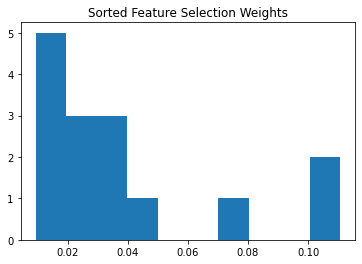

[838, 715, 908, 628, 753, 939, 676, 286, 112, 360]
[838, 715, 908, 628, 753, 939, 676, 286, 112, 360, 975, 698, 788, 714, 674, 314, 775, 584, 139, 650, 814, 315, 294, 807, 746]
[838, 715, 908, 628, 753, 939, 676, 286, 112, 360, 975, 698, 788, 714, 674, 314, 775, 584, 139, 650, 814, 315, 294, 807, 746, 585, 334, 392, 728, 547, 525, 356, 867, 174, 318, 319, 972, 69, 234, 602, 1016, 13, 747, 271, 722, 431, 561, 967, 607, 703]


In [178]:
top50feat = [x[0] for x in sorteddata][:50]
top10feat = [x[0] for x in sorteddata][:10]

plt.hist([i[1] for i in take(15,sorteddata)])
plt.title("Sorted Feature Selection Weights")

plt.show()
print(top10feat)
print(top25feat)
print(top50feat)


[838, 715, 908, 628, 753, 939, 676, 286, 112, 360, 975, 698, 788, 714, 674, 314, 775, 584, 139, 650, 814, 315, 294, 807, 746]
[0.11068158, 0.11045725, 0.07494791, 0.04689084, 0.03745973, 0.03692108, 0.03389258, 0.028189331, 0.027675645, 0.026248293]


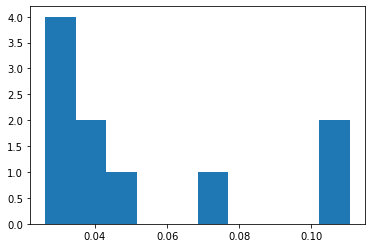

In [176]:
print(top25feat)
print([sorteddata[i][1] for i in range(10)])
plt.hist([sorteddata[i][1] for i in range(10)])
plt.show()


In [131]:
print(top25feat)

[838, 314, 715, 908, 628, 676, 286, 753, 360, 939, 112, 698, 975, 674, 775, 814, 584, 139, 714, 315, 294, 650, 234, 807, 585]


In [132]:
testidx = np.argsort(y_test)
#print(sorted(y_test))
print(testidx)
#print(len(testidx))
slice_conv = tuple(slice(x) for x in testidx)

[ 3095  9593  6269 ...  6533   700 11481]


In [133]:
print(testidx[0:100])

[ 3095  9593  6269  5967   527 11412  9977  8375  8669  3424  7611  8121
  6733  2692 11461  9164 10352  3970  1764  9142  4977  3544  5287  5958
  8430  8031  7944  4349  1695  2949  3853 10193  4615  1844  2092  4826
 10822  1546  9102 11087  5559  6971  1224   548  8147  7115  5286  2839
  3493 10767  6399 11636  1437  5426 10016  6085  2820   113  4010  4849
  9993 11302  1170   922  2476  3331  7582  4884  6304  2947    91  9748
  6324  5115  5563  5293  6207  7554  7587  6050  7508  8159  9849   123
 10501  5246  9615  8641  6173  9173  5791  7254  1038 10405  1428  5883
 11380  3840  3229  8898]


In [134]:
#slice_conv = tuple(slice(x) for x in testidx)
#print(x_test[testidx][0:4])
#print(reg.predict(x_test[testidx][0].reshape(1,-1)))
#print(reg.predict(x_test[testidx][0:4]))
#print(y_test[0:4])
#print(onbit)
#print(set(onbit))
#print(set(top50feat))
#print(set(onbit) & set(top50feat))

61180
11637


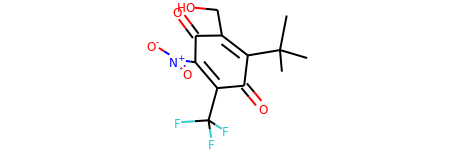

In [135]:
from rdkit.Chem import RDConfig
from rdkit.Chem import rdBase
print(len(molArr))
print(max(testidx))
testmols = [molArr[i] for i in testidx]
testmols[1]

In [136]:
pd.set_option('display.max_colwidth', -1)


def depictBit(bitId,mol,molSize=(450,200)):
    info={}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,radius=2,nBits=2048,bitInfo=info)
    aid,rad = info[bitId][0]
    return getSubstructDepiction(mol,aid,rad,molSize=molSize)

def get_thumbnail(path):
    path = "\\\\?\\"+path # This "\\\\?\\" is used to prevent problems with long Windows paths
    i = Image.open(path)    
    return i

def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'jpeg')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html(formatters={'Image': image_formatter}, escape=False) + css).replace("\n",'\\') + '\';'
    s += '</script>'

    return(HTML(s+css))

/home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [151]:
#output for single molecule
tpls = []
testmols = testmols[0:10]

for i in range(len(testmols)):
    #print([i for i in testidx])
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(testmols[i], 2, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    onbit = [bit for bit in bitInfo.keys()]
    #print(onbit)
    #print(top10feat)
    importantonbits = list(set(onbit) & set(top50feat))
    #print(importantonbits)
    #append to this array 
    if (importantonbits != []):
        tpls.append([(testmols[test_probe], x, bitInfo) for x in importantonbits])
    #print(tpls[1][2])

          
#print(tpls)
img = []
rows = []
for frag in tpls: 
    img.append(getSubstructDepiction(frag[0][0],frag[0][1],frag[0][2],molSize=(450,200)))
    fp = frag[0][1]
    img = Draw.DrawMorganBit(frag[0][0], frag[0][1], frag[0][2])
    img.append(Draw.DrawMorganBits(frag))
    rows.append([fp, img])
df = pd.DataFrame(rows, columns=("FP", "Image"))
df.head()
HTML(df.to_html(formatters={'Image': image_formatter}, escape=False))
#View(df)


IndexError: list index out of range

In [142]:
testmols = [molArr[i] for i in testidx]
slice_conv = tuple(slice(x) for x in testidx)

#testmols = molArr[slice(testidx[0])]
#test_probe = 1:10
for i in range(10):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(testmols[i], 2, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    onbit = [bit for bit in bitInfo.keys()]

    importantonbits = list(set(onbit) & set(top25feat))
    tpls.extend([(testmols[test_probe], x, bitInfo) for x in importantonbits])
    
Draw.DrawMorganBits(tpls)

ValueError: bad atom index

In [ ]:
tpls_full = []
testmols = [molArr[i] for i in testidx]
slice_conv = tuple(slice(x) for x in testidx)
testmols = molArr[slice(testidx[0])]
tpls = []

for i in range(int(len(testmols)/100)):
    bitInfo={}
    fp = AllChem.GetMorganFingerprintAsBitVect(testmols[test_probe], 2, bitInfo=bitInfo)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    onbit = [bit for bit in bitInfo.keys()]
    importantonbits = list(set(onbit) & set(top10feat))
    tpls_temp = [(testmols[test_probe], x, bitInfo) for x in importantonbits]
    tpls = tpls + tpls_temp

Draw.DrawMorganBits(tpls, molsPerRow=6)


In [ ]:
print(len(no_repeat))
print(len(tpls))
print(no_repeat)
#Draw.DrawMorganBits(no_repeat)

In [ ]:
top_feat = [x[:, i] for i in top10feat]
print(len(x[:,1]))
import pandas as pd 
df = pd.DataFrame(top_feat)
df = df.transpose()
df["HOMO"] = y
df.corr()
#print(np.shape(y))
#print(np.shape(np.delete(y, [267])))
#print(np.delete(np.delete(y, [6990]), [267]))
#df["HOMO"] = np.delete(y, [267])

In [ ]:
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
corr = np.array(df.corr()["HOMO"].to_numpy())[0:-1]
ax = plt.subplot(1,1,1)

plt.title("Correlation Top Fingerprints vs. HOMO")
ax.bar(range(10), corr)
print([str(i) for i in top10feat])
ax.set_xticklabels([str(i) for i in top10feat], rotation="45")
ax.set_xticks(np.arange(len(top10feat)))
plt.show()

In [ ]:
prin
def find_corr_for_index(x, y, ind):

    
    return corr